<a href="https://colab.research.google.com/github/myGithubAccount26/Biostatistics/blob/master/Biostatistics_Lab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
!pip install flashtorch
!pip install barbar
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-mhg3ck_2
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-mhg3ck_2
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7323 sha256=0f80d8dd1848f7a1d2fdd27a645e64b00738913cdfaa1ca7f4544db241cb166c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9aghgtlp/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=ff6be4b660643f16f5875d81b480a307afb0abc76cef6f9a983cb7c9b7bd8abe
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch


In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [3]:
%cd /content/drive/MyDrive/Data1/
%ls

/content/drive/MyDrive/Data1
antsbeesdataset/  Dogbreeddataset/  flowers102/  Iris.csv


In [4]:
os.chdir('/content/drive/MyDrive/Data1/Dogbreeddataset')

In [5]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
poodle = load_images_from_folder('Poodle')

In [11]:
len(poodle)

603

In [12]:
r = np.random.permutation(len(poodle))

In [52]:
import random

random.randint(1, 10)

10

In [ ]:
os.listdir('/content/drive/MyDrive/Data1/Dogbreeddataset/Poodle')

In [56]:
import os
import shutil
source = '/content/drive/MyDrive/Data1/Dogbreeddataset/Poodle'
validation = '/content/drive/MyDrive/Data1/Dogbreeddataset/valid'
training = '/content/drive/MyDrive/Data1/Dogbreeddataset/train'

def split_test_train(source, validation, training):
  for filename in os.listdir(source):
    if(random.randint(1,10) > 8):
      shutil.move(os.path.join(source,filename), os.path.join(validation,filename))
    else:
      shutil.move(os.path.join(source,filename), os.path.join(training,filename))

In [60]:
split_test_train('/content/drive/MyDrive/Data1/Dogbreeddataset/Siberian_Husky', '/content/drive/MyDrive/Data1/Dogbreeddataset/valid/Husky', '/content/drive/MyDrive/Data1/Dogbreeddataset/train/Husky')

In [17]:
shutil.move(os.path.join('/content/drive/MyDrive/Data1/Dogbreeddataset/Poodle', 'image16.jpeg'), os.path.join('/content/drive/MyDrive/Data1/Dogbreeddataset/train', 'image16.jpeg'))

'/content/drive/MyDrive/Data1/Dogbreeddataset/train/image16.jpeg'

In [61]:
data_dir = '/content/drive/My Drive/Data1/Dogbreeddataset/'

In [62]:
os.chdir(data_dir)

In [94]:
## Note, this must be in order of your folders (alphabetical)
dataset_labels =["Husky", "Labrador", "Poodle", "Pug"] #<--- Replace with your labels 

In [95]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(1000),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(1000),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [96]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [66]:
dataset_sizes

{'train': 1783, 'valid': 471}

In [93]:
image_datasets['train'].classes

['Husky', 'Labrador', 'Poodle', 'Pug']

In [97]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

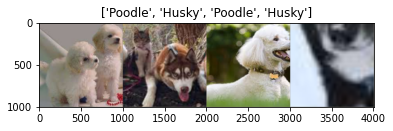

In [99]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [91]:
dataset_labels

['Poodle', 'Labrador', 'Husky', 'Pug']

In [100]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [101]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.40
Valid  Acc: 0.25
#######################
Epoch:  2 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.56
Valid  Acc: 0.25
#######################
Epoch:  3 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.64
Valid  Acc: 0.42
#######################
Epoch:  4 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.67
Valid  Acc: 0.44
#######################
Epoch:  5 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.71
Valid  Acc: 0.31
#######################
Epoch:  6 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.78
Valid  Acc: 0.57
#######################
Epoch:  7 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.79
Valid  Acc: 0.42
#######################
Epoch:  8 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.81
Valid  Acc: 0.43
#######################
Epoch:  9 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.84
Valid  Acc: 0.68
#######################
Epoch:  10 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.82
Valid  Acc: 0.61
#######################
Epoch:  11 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.83
Valid  Acc: 0.58
#######################
Epoch:  12 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.84
Valid  Acc: 0.59
#######################
Epoch:  13 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.84
Valid  Acc: 0.65
#######################
Epoch:  14 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.83
Valid  Acc: 0.57
#######################
Epoch:  15 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.85
Valid  Acc: 0.67
#######################
Epoch:  16 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.86
Valid  Acc: 0.55
#######################
Epoch:  17 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.86
Valid  Acc: 0.63
#######################
Epoch:  18 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.85
Valid  Acc: 0.63
#######################
Epoch:  19 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.86
Valid  Acc: 0.57
#######################
Epoch:  20 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.85
Valid  Acc: 0.61
#######################
Epoch:  21 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.85
Valid  Acc: 0.64
#######################
Epoch:  22 / 30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train  Acc: 0.85
Valid  Acc: 0.65
#######################
Epoch:  23 / 30


In [47]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

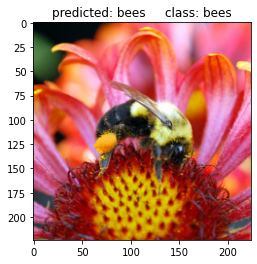

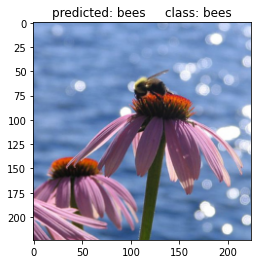

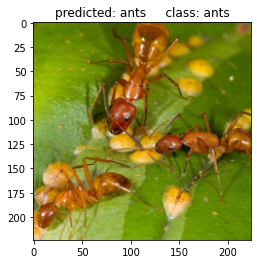

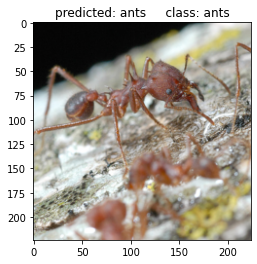

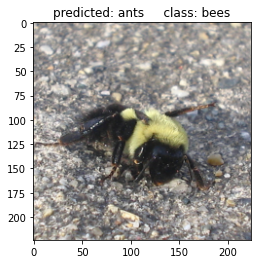

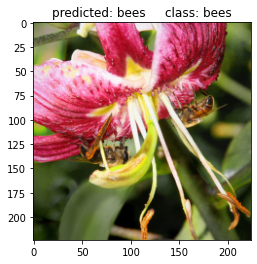

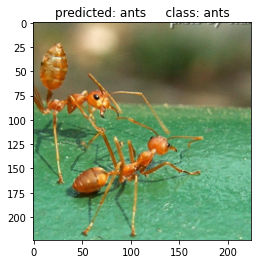

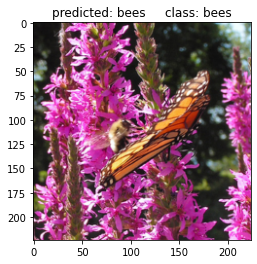

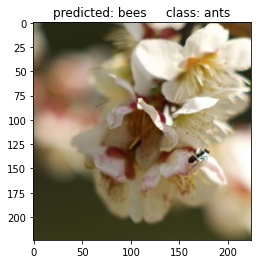

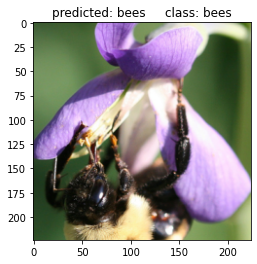

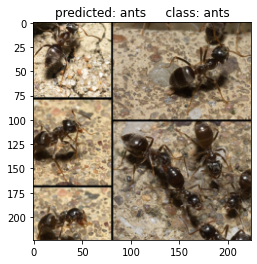

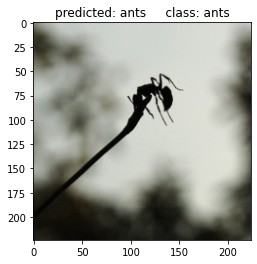

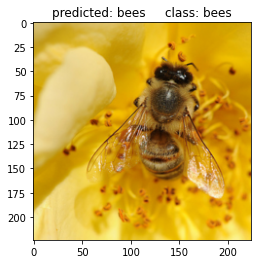

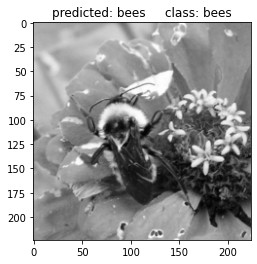

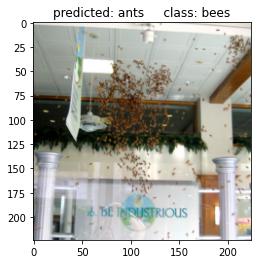

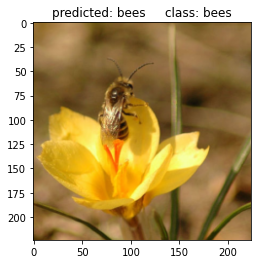

In [48]:
visualize_model(model)

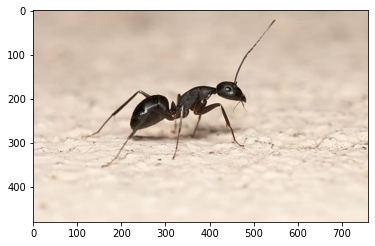

In [49]:
image = io.imread('https://cdn.branchcms.com/7XlaZw139w-1201/images/ant-pest-image.v1.jpg')
plt.imshow(image);

In [50]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [51]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [52]:
print('predicted: ' + dataset_labels[preds])

predicted: ants


In [53]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [55]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [56]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [57]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[67,  7],
       [ 3, 76]])

Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [ ]:
cm[0,0]

67

In [ ]:
cm[1,1]

79

In [ ]:
cm[0,1]

4

In [ ]:
cm[1,0]

3